In [1]:
import geatpy as ea
import pandas as pd
import math
from sklearn.metrics import mean_squared_error
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KDTree
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU,Dropout
from pyDOE import lhs
from keras import optimizers
from numpy import concatenate
import json
import numpy as np
import geatpy as ea
import pandas as pd
import matplotlib.pyplot as plt  # 用来绘图的库
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.ensemble import AdaBoostRegressor
from numpy import concatenate
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU
from keras import optimizers
from sklearn.svm import SVR
from matplotlib import pyplot


import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, MultiHeadAttention, LayerNormalization, Dropout
from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
from numpy import concatenate
import pandas as pd
import matplotlib.pyplot as plt  # 用来绘图的库
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from math import sqrt
from sklearn.ensemble import AdaBoostRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU
from keras import optimizers
from sklearn.svm import SVR
import numpy as np
import re
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
import tensorflow as tf
from tensorflow.compat.v1 import InteractiveSession
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

EA_NAME = ['soea_DE_best_1_bin_templet','soea_DE_best_1_L_templet','soea_DE_rand_1_bin_templet',
           'soea_SGA_templet','soea_EGA_templet','soea_steadyGA_templet','soea_SEGA_templet','soea_SEGA_templet']

In [2]:
def calcul_indicator(y,yhat):
    EV = 1 - np.var(y - yhat)/np.var(y)
    MAE = np.sum(np.abs((y - yhat)))/len(y)
    MSE = np.sum(np.multiply((y - yhat),(y - yhat)))/len(y)
    RMSE = sqrt(MSE)
    R_square = 1 - (((y - yhat)**2).sum())/(((y - y.mean())**2).sum())
    return [EV,MAE,MSE,RMSE,R_square]

class ArtificialImmuneNetwork:
    def __init__(self, fitness_func, num_parameters, population_size, num_generations, clone_factor, mutation_rate, suppression_threshold, memory_pool_size,early_stopping_patience):
        self.fitness_func = fitness_func
        self.num_parameters = num_parameters
        self.population_size = population_size
        self.num_generations = num_generations
        self.clone_factor = clone_factor
        self.mutation_rate = mutation_rate
        self.suppression_threshold = suppression_threshold
        self.memory_pool_size = memory_pool_size
        self.early_stopping_patience = early_stopping_patience
        

    def initialize_population(self):
        # 使用拉丁超立方抽样生成初始种群
        initial_population = lhs(self.num_parameters, samples=self.population_size)
        return initial_population

    def clone(self, population, fitness_values):
        # 计算最大适应度值
        max_fitness = np.max(fitness_values)
        min_fitness = np.min(fitness_values)
        # 计算个体的调整适应度值,确保值在(0, 1]范围内
        adjusted_fitness = (max_fitness - fitness_values + 1e-10) / (max_fitness - min_fitness + 1e-10)

        clones = []
        for antibody, fitness in zip(population, adjusted_fitness):
            # 计算克隆数量,根据调整适应度值和克隆因子
            num_clones = int(self.clone_factor * fitness)

            # 生成克隆个体
            clones.extend([antibody.copy() for _ in range(num_clones)])

        return np.array(clones)


    def mutate(self, clones):
        mutation_mask = np.random.rand(*clones.shape) < self.mutation_rate
        gaussian_noise = np.random.normal(0, self.mutation_rate, size=clones.shape)
        clones[mutation_mask] += gaussian_noise[mutation_mask]
        clones = np.clip(clones, 0, 1)
        return clones
    
    # def suppress(self, antibodies):
    #     suppressed_antibodies = []
    #     for i in range(len(antibodies)):
    #         too_close = False
    #         for j in range(len(suppressed_antibodies)):
    #             if np.linalg.norm(antibodies[i] - suppressed_antibodies[j]) < self.suppression_threshold:
    #                 too_close = True
    #                 break
    #         if not too_close:
    #             suppressed_antibodies.append(antibodies[i])
    #     return np.array(suppressed_antibodies)
    
    def suppress(self, antibodies):
        if len(antibodies) == 0:
            return np.array([])

        kdt = KDTree(antibodies, leaf_size=30, metric='euclidean')
        suppressed_antibodies = []
        indices_to_remove = set()

        for i in range(len(antibodies)):
            if i in indices_to_remove:
                continue
            suppressed_antibodies.append(antibodies[i])
            ind = kdt.query_radius(antibodies[i].reshape(1, -1), r=self.suppression_threshold)[0]
            indices_to_remove.update(ind.tolist())

        return np.array(suppressed_antibodies)

    # def network_interaction(self, population, fitness_values):
    #     # 计算个体之间的距离矩阵
    #     distances = np.zeros((len(population), len(population)))
    #     for i in range(len(population)):
    #         for j in range(i + 1, len(population)):
    #             distances[i, j] = distances[j, i] = np.linalg.norm(population[i] - population[j])

    #     # 计算个体之间的亲和力
    #     affinities = 1 / (distances + 1e-10)  # 添加一个小的正数,以避免除以零

    #     # 根据亲和力对个体进行交互
    #     for i in range(len(population)):
    #         for j in range(len(population)):
    #             if i != j:
    #                 interaction_strength = affinities[i, j] * (fitness_values[j] - fitness_values[i])
    #                 population[i] += interaction_strength * (population[j] - population[i])

    #     return population

    def maintain_memory_pool(self, population, fitness_values, memory_pool):
        # 将最佳个体添加到记忆库中
        best_indices = np.argsort(fitness_values)[:self.memory_pool_size]
        memory_pool = np.vstack((memory_pool, population[best_indices]))
        
        # 从记忆库中删除重复的个体
        memory_pool = np.unique(memory_pool, axis=0)
        
        # 如果记忆库大小超过限制,删除适应度较差的个体
        if memory_pool.shape[0] > self.memory_pool_size:
            pool_fitness = np.apply_along_axis(self.fitness_func, 1, memory_pool)
            best_indices = np.argsort(pool_fitness)[:self.memory_pool_size]
            memory_pool = memory_pool[best_indices]
        
        return memory_pool

    def optimize(self):
        population = self.initialize_population()
        memory_pool = np.empty((0, self.num_parameters))
        best_fitness = np.inf
        patience_counter = 0

        for generation in range(self.num_generations):
            fitness_values = np.apply_along_axis(self.fitness_func, 1, population)
            clones = self.clone(population, fitness_values)
            mutated_clones = self.mutate(clones)
            combined_population = np.vstack((population, mutated_clones))
            combined_population = self.suppress(combined_population)
            memory_pool = self.maintain_memory_pool(combined_population, np.apply_along_axis(self.fitness_func, 1, combined_population), memory_pool)
            combined_fitness = np.apply_along_axis(self.fitness_func, 1, combined_population)
            best_indices = np.argsort(combined_fitness)[:self.population_size]
            population = combined_population[best_indices]

            current_best_fitness = np.min(combined_fitness)
            if current_best_fitness < best_fitness:
                best_fitness = current_best_fitness
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= self.early_stopping_patience:
                    print(f"Early stopping at generation {generation}")
                    break

        best_index = np.argmin(np.apply_along_axis(self.fitness_func, 1, memory_pool))
        return memory_pool[best_index]


def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def RandomForest(train_X,train_y,test_X,test_y):
    model = RandomForestRegressor(n_estimators=25)
    history = model.fit(train_X, train_y)
    yhat = (history.predict(test_X)).T
    yhat = yhat.reshape(len(yhat), 1)
    test_y = test_y.reshape(len(test_y), 1)
    return calcul_indicator(test_y, yhat)

def Adaboost(train_X,train_y,test_X,test_y):
    model = AdaBoostRegressor(n_estimators=50)
    history = model.fit(train_X, train_y)
    yhat = (history.predict(test_X)).T
    yhat = yhat.reshape(len(yhat), 1)
    test_y = test_y.reshape(len(test_y), 1)
    return calcul_indicator(test_y, yhat)

def LR(train_X,train_y,test_X,test_y):
    model = Sequential()
    model.add(Dense(1, input_dim=train_X.shape[1]))
    model.compile(loss='mse', optimizer='Adam')
    history = model.fit(train_X, train_y, batch_size=60, epochs=32, validation_data=(test_X, test_y), verbose=1,
                        shuffle=False)
    yhat = model.predict(test_X)
    yhat = yhat.reshape(len(yhat), 1)
    test_y = test_y.reshape(len(test_y), 1)
    return calcul_indicator(test_y, yhat)

def SVRR(train_X,train_y,test_X,test_y):
    model = SVR(kernel='poly')
    history = model.fit(train_X, train_y)
    yhat = (history.predict(test_X)).T
    yhat = yhat.reshape(len(yhat), 1)
    test_y = test_y.reshape(len(test_y), 1)
    return calcul_indicator(test_y, yhat)


def GRUM(train_X,train_y,test_X,test_y):
    # 将数据转换成3D进行输入
    train_X_GRU = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X_GRU = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    model = Sequential()
    model.add(GRU(100, input_shape=(train_X_GRU.shape[1], train_X_GRU.shape[2])))  #神经元数可以调少一点，比如80
    model.add(Dropout(0.2))
    model.add(Dense(1))
    # Compile model
    learning_rate = 0.00045   #学习率可以试一试别的，一般在0.001到0.0001之间，可以试试0.0003
    decay_rate = 0.00003    #可以调
    momentum = 0.5
    sgd = optimizers.gradient_descent_v2.SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate,
                                             nesterov=False)
    model.compile(loss='mse', optimizer=sgd)
    # fit network
    history = model.fit(train_X_GRU, train_y, epochs=100, batch_size=32, validation_data=(test_X_GRU, test_y),
                        verbose=1, shuffle=False)
    yhat = model.predict(test_X_GRU)
    yhat = yhat.reshape(len(yhat), 1)
    plt.cla()
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.ylabel('loss/val_loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()
    test_y = test_y.reshape(len(test_y), 1)
    return calcul_indicator(test_y,yhat)



#优化的GRU模型
def OptimizedGRU(train_X, train_y, test_X, test_y, calcul_indicator):
    def GRU_fitness(params):
       
        train_X_GRU = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
        test_X_GRU = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

        num_units = 50 + int(params[0] * 150)  # GRU 单元数 (50 to 150)
        dropout_rate = params[2]*0.5  # Dropout率 (0 to 0.5)
        learning_rate = params[1] * 0.01 + 0.0001  # 学习率 (0.0001 to 0.01)  
        epochs = 30 + int(params[3] * 100)  # epochs (50 to 150)
        batch_size = 8+ int(params[4] * 120)  # batch_size (2 to 100)
        
        model = Sequential()
        model.add(GRU(num_units, input_shape=(train_X_GRU.shape[1], train_X_GRU.shape[2])))
        model.add(Dropout(dropout_rate))
        model.add(Dense(1))

   
        decay_rate = 0.000003
        momentum = 0.5
        sgd = optimizers.gradient_descent_v2.SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
        model.compile(loss='mse', optimizer=sgd)

        history = model.fit(train_X_GRU, train_y, epochs=epochs, batch_size=batch_size, validation_data=(test_X_GRU, test_y), verbose=1, shuffle=False)

        yhat = model.predict(test_X_GRU)
        yhat = yhat.reshape(len(yhat), 1)
        test_y_reshaped = test_y.reshape(len(test_y), 1)

        indicators = calcul_indicator(test_y_reshaped, yhat)
        fitness = indicators[3]# RMSE作为适应度值
        return fitness


    # 使用免疫网络算法找到最优参数
    ain = ArtificialImmuneNetwork(GRU_fitness, 5, 15, 20, 4, 0.3, 0.08, 5, 3)   #免疫网络参数设置
    best_params = ain.optimize()

    # 使用最优参数训练GRU模型
    best_num_units = 50 + int(best_params[0] * 150)
    best_learning_rate = best_params[1] * 0.01 + 0.0001
    best_dropout = best_params[2]*0.5
    best_epochs = 30 + int(best_params[3] * 100)  # epochs (50 to 150)
    best_batch_size=8+ int(best_params[4] * 120)
    
    train_X_GRU = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X_GRU = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

    model = Sequential()
    model.add(GRU(best_num_units, input_shape=(train_X_GRU.shape[1], train_X_GRU.shape[2])))
    model.add(Dropout(best_dropout))
    model.add(Dense(1))

    decay_rate = 0.000003
    momentum = 0.5
    sgd = optimizers.gradient_descent_v2.SGD(learning_rate=best_learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
    model.compile(loss='mse', optimizer=sgd)

    history = model.fit(train_X_GRU, train_y, epochs=best_epochs , batch_size=best_batch_size , validation_data=(test_X_GRU, test_y), verbose=1, shuffle=False)

    yhat = model.predict(test_X_GRU)
    yhat = yhat.reshape(len(yhat), 1)
    test_y_reshaped = test_y.reshape(len(test_y), 1)

    # 绘制损失曲线
    plt.cla()
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.ylabel('loss/val_loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

    # 返回模型评估结果和最优参数
    return calcul_indicator(test_y_reshaped, yhat)

C:\Users\admin\AppData\Local\Temp\ipykernel_2448\1547306262.py:41: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,method] = RandomForest(train_X,train_y,test_X,test_y)


Epoch 1/32
 1/13 [=>............................] - ETA: 1s - loss: 0.1140

C:\Users\admin\AppData\Local\Temp\ipykernel_2448\1547306262.py:43: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,method] = Adaboost(train_X,train_y,test_X,test_y)


13/13 [==============================] - 0s 6ms/step - loss: 0.1353 - val_loss: 0.1110
Epoch 2/32
13/13 [==============================] - 0s 1ms/step - loss: 0.0654 - val_loss: 0.0456
Epoch 3/32
13/13 [==============================] - 0s 1ms/step - loss: 0.0462 - val_loss: 0.0282
Epoch 4/32
13/13 [==============================] - 0s 1ms/step - loss: 0.0346 - val_loss: 0.0228
Epoch 5/32
13/13 [==============================] - 0s 1ms/step - loss: 0.0278 - val_loss: 0.0183
Epoch 6/32
13/13 [==============================] - 0s 1ms/step - loss: 0.0239 - val_loss: 0.0146
Epoch 7/32
13/13 [==============================] - 0s 1ms/step - loss: 0.0218 - val_loss: 0.0127
Epoch 8/32
13/13 [==============================] - 0s 1ms/step - loss: 0.0206 - val_loss: 0.0120
Epoch 9/32
13/13 [==============================] - 0s 1ms/step - loss: 0.0198 - val_loss: 0.0117
Epoch 10/32
13/13 [==============================] - 0s 2ms/step - loss: 0.0193 - val_loss: 0.0115
Epoch 11/32
13/13 [===========

C:\Users\admin\AppData\Local\Temp\ipykernel_2448\1547306262.py:45: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,method] = LR(train_X,train_y,test_X,test_y)
C:\Users\admin\AppData\Local\Temp\ipykernel_2448\1547306262.py:47: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,method] = SVRR(train_X,train_y,test_X,test_y)


Epoch 1/100
24/24 [==============================] - 1s 8ms/step - loss: 0.0476 - val_loss: 0.0108
Epoch 2/100
24/24 [==============================] - 0s 2ms/step - loss: 0.0379 - val_loss: 0.0113
Epoch 3/100
24/24 [==============================] - 0s 2ms/step - loss: 0.0288 - val_loss: 0.0128
Epoch 4/100
24/24 [==============================] - 0s 1ms/step - loss: 0.0272 - val_loss: 0.0145
Epoch 5/100
24/24 [==============================] - 0s 2ms/step - loss: 0.0250 - val_loss: 0.0160
Epoch 6/100
24/24 [==============================] - 0s 1ms/step - loss: 0.0241 - val_loss: 0.0173
Epoch 7/100
24/24 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0184
Epoch 8/100
24/24 [==============================] - 0s 2ms/step - loss: 0.0227 - val_loss: 0.0192
Epoch 9/100
24/24 [==============================] - 0s 2ms/step - loss: 0.0226 - val_loss: 0.0197
Epoch 10/100
24/24 [==============================] - 0s 2ms/step - loss: 0.0215 - val_loss: 0.0203
Epoch 11/

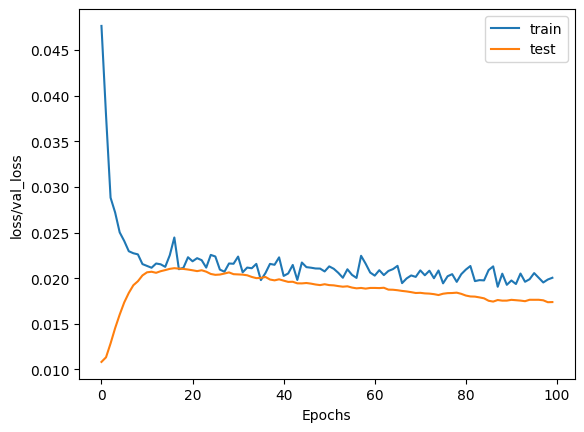

C:\Users\admin\AppData\Local\Temp\ipykernel_2448\1547306262.py:49: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,method] = GRUM(train_X,train_y,test_X,test_y)


IndexError: index 94 is out of bounds for axis 0 with size 94

In [3]:
if __name__ == '__main__':
    areas = ['DS2']
    indicator = ['EV','MAE','MSE','RMSE','R_square']

    # 如果是需要改动对比的算法，在这里进行改进即可
    classifers = ['RF','Adaboost','LinearRegression','SVR','GRU','GGAPSGA-RF','GGAPSGA-Adaboost','GGAPSGA-LinearRegression','GGAPSGA-SVR','GGAPSGA-GRU','ImmuneNetwork','GGAPSGA-ImmuneNetwork']
    df = pd.DataFrame(columns=classifers, index=indicator)
    #df = pd.DataFrame()
    for area in areas:
        path = './{}/'.format(area)
        pre_data_df = pd.read_csv(path+'8area_{}.csv'.format(area))
        # 对每种方法进行遍历
        for method in classifers:
            data_df  =pre_data_df
            if method[:4]=='GGAP':
                res = pd.read_csv(path+'soea_GGAP_SGA_templet/optPop/Chrom.csv',header=None)
                values = res.values
                features = data_df.columns[1:]
                best_features = []
                best_features.append('label_M')
                for index in range(values.shape[1]):
                     if values[0][index] == 1:#筛选出来的特征，如果是1则选上，如果是0，则不选。
                         best_features.append(features[index])
                data_df = data_df[best_features]
            values = data_df.values
            values = values.astype('float32')
            #进行标准化的操作
            scaler = MinMaxScaler(feature_range = (0,1))
            scaled = scaler.fit_transform(values)
            reframed = series_to_supervised(scaled,1,1)
            reframed.drop(reframed.columns[[i for i in range(int(reframed.shape[1] / 2) + 1, reframed.shape[1])]], axis=1,inplace=True)

            #split into input
            values = reframed.values
            n_train_hours = int(reframed.shape[0]*0.7)
            train = values[:n_train_hours:]
            test = values[n_train_hours:,:]
            train_X,train_y = train[:,:-1],train[:,-1]
            test_X ,test_y = test[:,:-1],test[:,-1]
            if re.search('RF', method):
                df.loc[:,method] = RandomForest(train_X,train_y,test_X,test_y)
            elif re.search('Adaboost',method):
                df.loc[:,method] = Adaboost(train_X,train_y,test_X,test_y)
            elif re.search('LinearRegression',method):
                df.loc[:,method] = LR(train_X,train_y,test_X,test_y)
            elif re.search('SVR', method):
                df.loc[:,method] = SVRR(train_X,train_y,test_X,test_y)
            elif re.search('GRU', method):
                df.loc[:,method] = GRUM(train_X,train_y,test_X,test_y)
            elif re.search('ImmuneNetwork', method):
                indicators = OptimizedGRU(train_X, train_y, test_X, test_y, calcul_indicator)
                df.loc[:,method]=indicators
        df.to_csv(path+'comparision_methodsgru530_{}.csv'.format(area))